Получение данных 

In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
from numpy import linalg
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt

chips = open('./chips.txt', 'r')
chips.readline()
dataPlain = []
for line in chips:
    row = line.replace(',','.').split()
    clazz = int(row[2])
    dataPlain.append([[float(row[0]),float(row[1])], -1 if clazz==0 else 1])
def coord(c,clazz):
    return map(lambda p: p[0][c], filter(lambda p: p[1]==clazz, dataPlain))
red = [coord(0, 1), coord(1, 1)]
blue = [coord(0, -1), coord(1, -1)]

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([-1, 1, -1, 1])
ax.scatter(red[0], red[1], c='r', s=25)
ax.scatter(blue[0], blue[1], c='b', s=25)
plt.show()

ImportError: dlopen(//anaconda/envs/python2/lib/python2.7/site-packages/cvxopt/lapack.so, 2): Symbol not found: _dgesv_
  Referenced from: //anaconda/envs/python2/lib/python2.7/site-packages/cvxopt/lapack.so
  Expected in: /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib


Выборка не является линейно разделимой

Ядра:

In [536]:
def lin(x1, x2):
    return np.dot(x1, x2)

def poly(x, y, p):
    return (1 + np.dot(x, y)) ** p

def gauss(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

Алгоритм

In [537]:
class SVM(object):

    def __init__(self, kernel, C):
        self.kernel = kernel
        self.C = float(C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * self.C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lambdas
        a = np.ravel(solution['x'])

        # Support vectors have non zero lambdas (lagrange multipliers)
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print "%d support vectors out of %d points" % (len(self.a), n_samples)

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a) # normalize weights

    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
            y_predict[i] = s
        return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

def split(x1, x2):
    size1 = int(len(x1[0])*test_percent)    
    size2 = int(len(x2[0])*test_percent)  
    train_x = np.vstack ((x1[0][size1:], x2[0][size2:]))
    train_y = np.hstack((x1[1][size1:], x2[1][size2:]))
    test_x = np.vstack ((x1[0][:size1], x2[0][:size2]))
    test_y = np.hstack((x1[1][:size1], x2[1][:size2]))
    return (train_x, train_y), (test_x, test_y)

def plot(X1_train, X2_train, svm):
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_axes([-1, 1, -1, 1])
    
    ax.scatter(svm.sv[:,0], svm.sv[:,1], s=100, c="black")
    ax.scatter(X1_train[:,0], X1_train[:,1], s=50, c='red')
    ax.scatter(X2_train[:,0], X2_train[:,1], s=50, c='blue')

    X1, X2 = np.meshgrid(np.linspace(-1,1,50), np.linspace(-1,1,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = svm.project(X).reshape(X1.shape)
    ax.contour(X1, X2, Z, [0.0], colors='green', linewidths=2, origin='lower')
    ax.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=2, origin='lower')
    ax.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=2, origin='lower')

    plt.axis("tight")
    plt.show()

Настройка параметров алгоритма:

In [538]:
def poly3(x,y):
    return poly(x,y,3)

kernel = poly3 # ядро
C = 0.01 # параметр SVM
test_percent = 0.1 # процентов датасета уйдет в тестовую выборку

     pcost       dcost       gap    pres   dres
 0: -2.8811e+01 -4.4366e+00  7e+02  3e+01  5e-15
 1: -4.5748e+00 -3.3254e+00  4e+01  2e+00  4e-15
 2: -8.2024e-01 -2.4309e+00  2e+00  6e-16  1e-15
 3: -9.3661e-01 -1.1892e+00  3e-01  6e-17  6e-16
 4: -1.0305e+00 -1.0529e+00  2e-02  7e-17  7e-16
 5: -1.0316e+00 -1.0397e+00  8e-03  3e-16  7e-16
 6: -1.0324e+00 -1.0404e+00  8e-03  4e-16  6e-16
 7: -1.0343e+00 -1.0356e+00  1e-03  5e-16  6e-16
 8: -1.0349e+00 -1.0349e+00  2e-05  3e-16  7e-16
 9: -1.0349e+00 -1.0349e+00  2e-07  3e-17  7e-16
Optimal solution found.
106 support vectors out of 107 points
10 out of 11 predictions correct


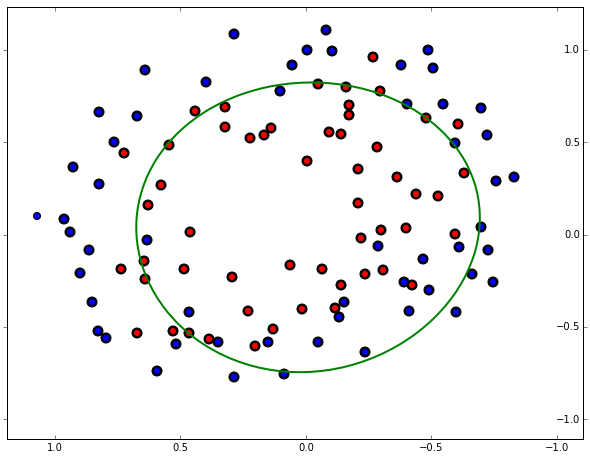

In [539]:
def test():
    X1 = map(lambda x: x[0], filter(lambda x: x[1] ==1, dataPlain))
    y1 = [1.0]*len(X1)
    X2 = map(lambda x: x[0], filter(lambda x: x[1] ==-1, dataPlain))
    y2 = [-1.0]*len(X2)
    train, test = split([X1, y1], [X2, y2])
    svm = SVM(kernel,C)
    svm.fit(train[0], train[1])

    y_predict = svm.predict(test[0])
    correct = np.sum(y_predict == test[1])
    print "%d out of %d predictions correct" % (correct, len(y_predict))

    plot(train[0][train[1]==1], train[0][train[1]==-1], svm)
    
test()